# Classical time series models using bayesian inference

In this notebook we will fit some basic time series model to our data using bayesian methods. To keep the problem simple, we will initially put our focus on just one time series

In [3]:
# redirect all output away from jupyter
nullFile <- file("all.Rout", open = "wt")
sink(nullFile)

library(readr);

# stan libraries
library(rstan);
library(parallel) # parallel computing

# plot utilities
library(ggplot2);
library(gridExtra)
library(purrr);
library(dplyr);

# graphical options
options(repr.plot.width=50, repr.plot.height=25)
options(warn=-1)

# set global plot theme
t =  theme_minimal() +
     theme(legend.position="none", 
           axis.text.x = element_text(face="bold", size=35),
           axis.text.y = element_text(face="bold", size=35), 
           text = element_text(size=40))

theme_set(t)

In [4]:
# load dataset
data = read_csv("../data/tsData.csv", col_types=cols());
head(data)

created_at,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,latitude,longitude,weekend,wind,rain
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-06-24 17:00:00,1024,7.02875,7.625000,7.502500,7.508750,35.71500,32.99125,45.45829,9.16756,0,2.0,0
2020-06-24 18:00:00,1024,5.52750,6.083333,6.405833,6.456667,35.63333,34.51250,45.45829,9.16756,0,1.8,0
2020-06-24 19:00:00,1024,5.91750,6.625000,6.907500,6.965000,34.97250,31.95875,45.45829,9.16756,0,1.7,0
2020-06-24 20:00:00,1024,NA,NA,NA,NA,NA,NA,45.45829,9.16756,0,1.4,0
2020-06-24 21:00:00,1024,NA,NA,NA,NA,NA,NA,45.45829,9.16756,0,2.0,0
2020-06-24 22:00:00,1024,NA,NA,NA,NA,NA,NA,45.45829,9.16756,0,2.0,0


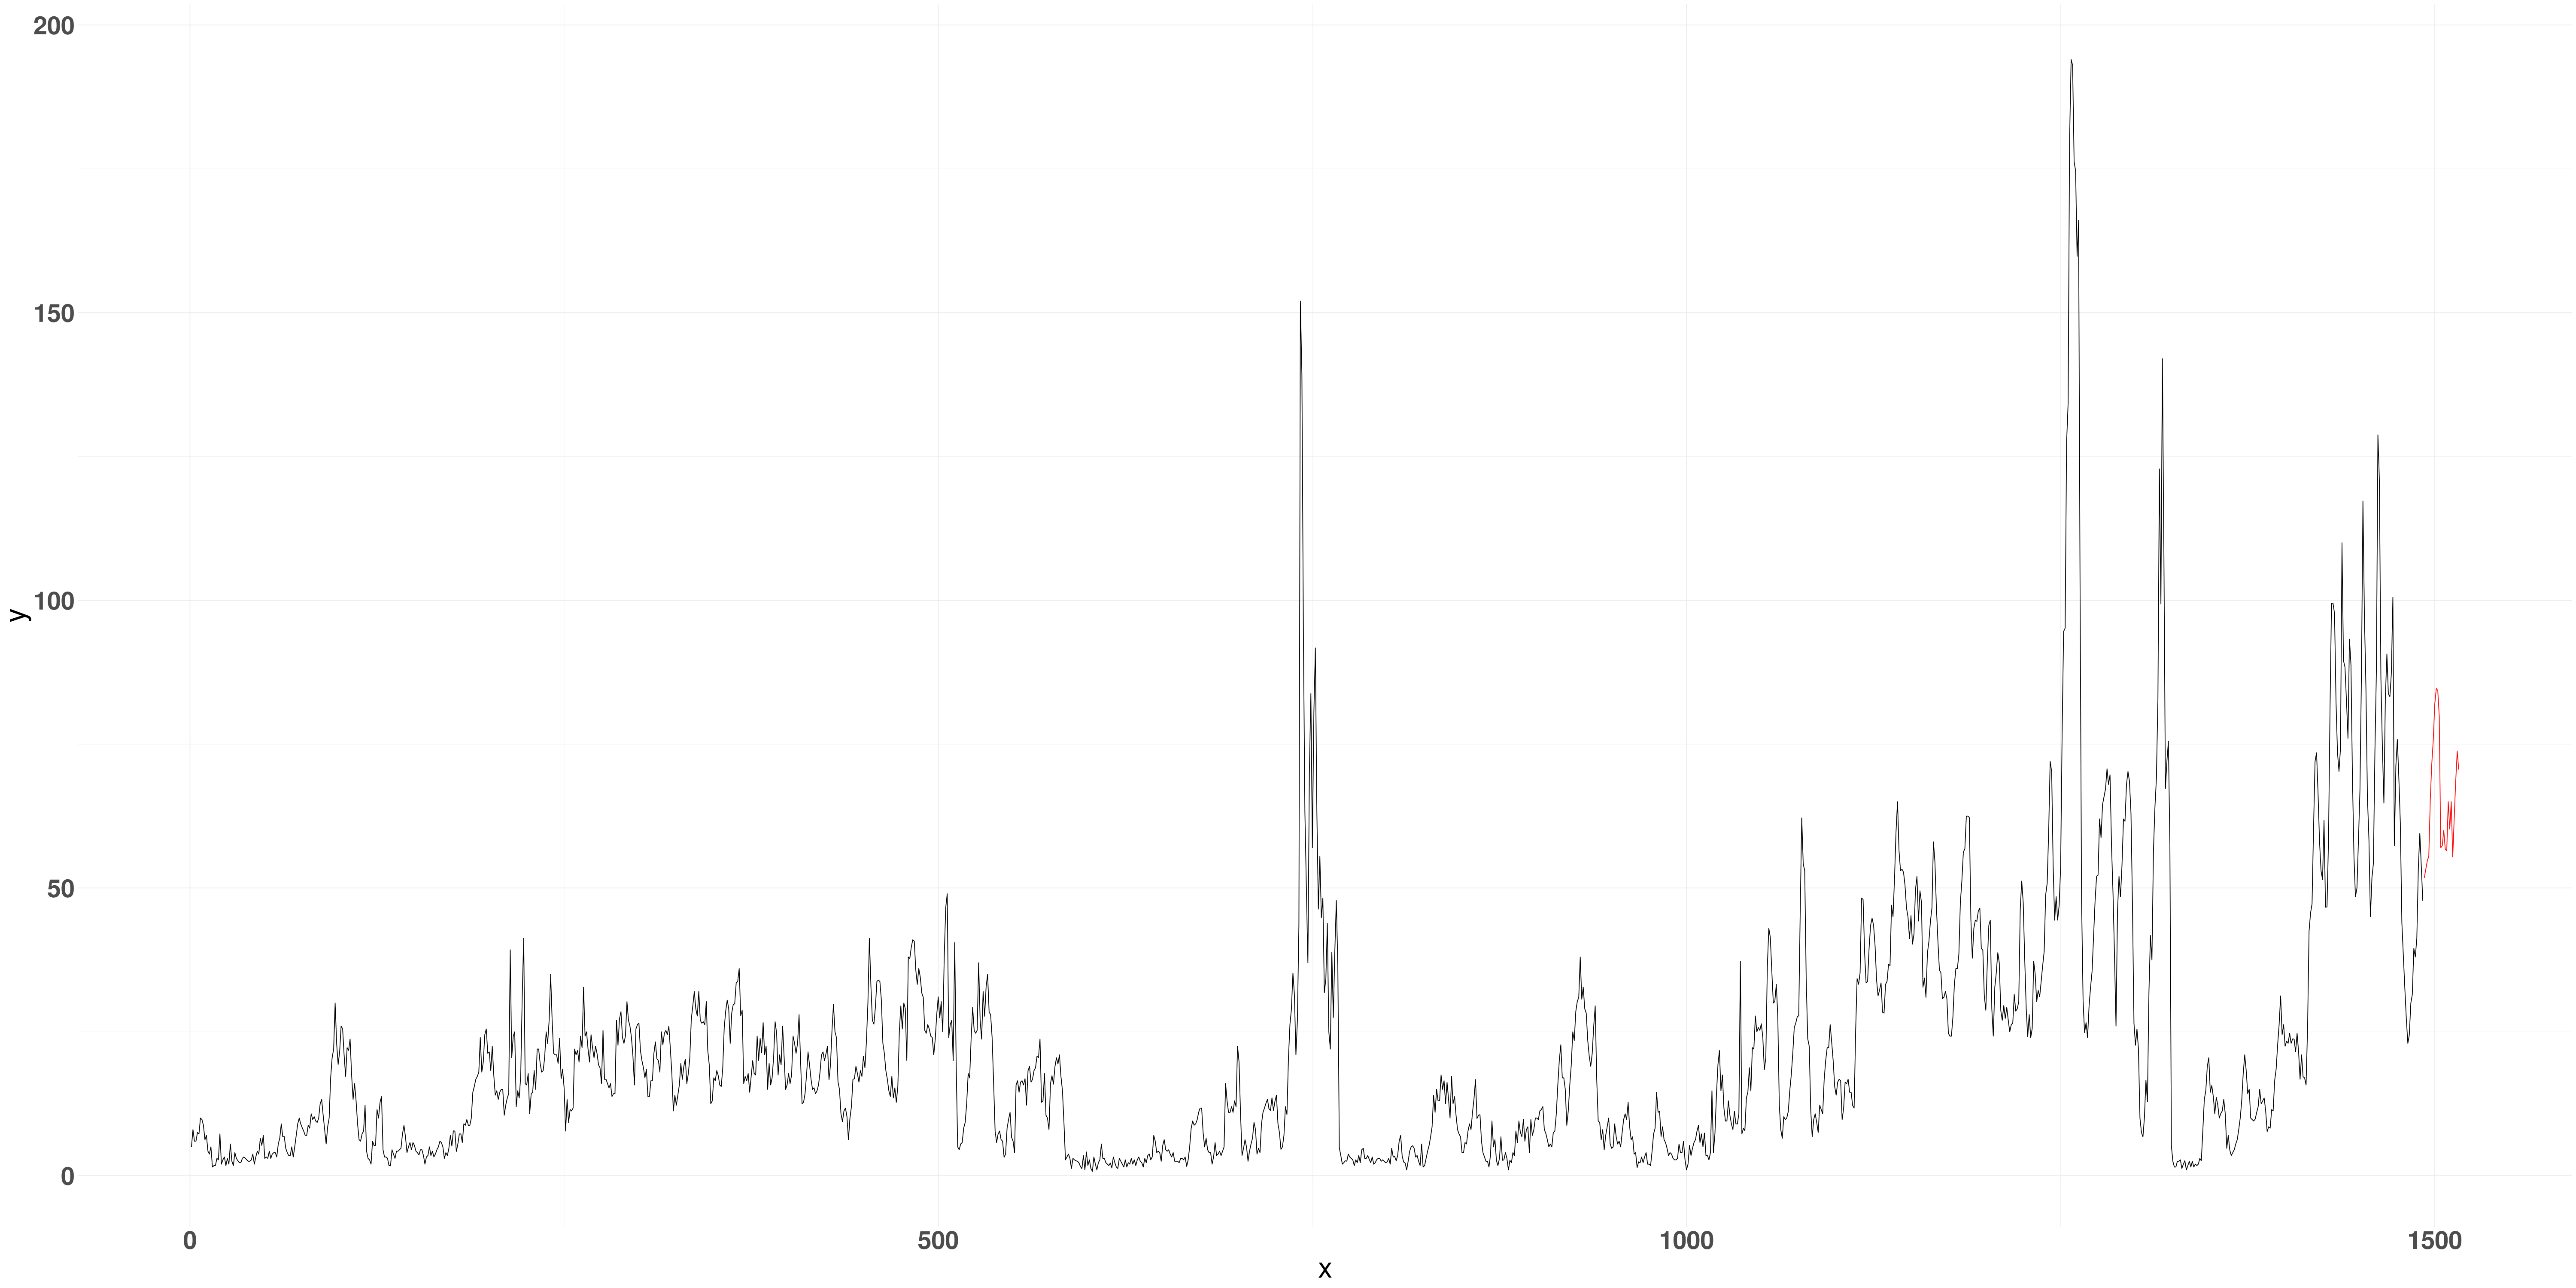

In [5]:
# focus on the time series we are interested in
interestingPot = 1091
startDate      = "2020-09-01"
endDate        = "2020-11-03"

# number of days to forecast (this will be used to build the test set)
fd = 1

# train dataset
Ytrain = data$pm2p5SPS[data$created_at > parse_datetime(startDate) &
                       data$created_at < parse_datetime(endDate)   &
                       data$pot_id == interestingPot];
Ytrain = Ytrain[!is.na(Ytrain)]; # drop NaN
N = length(Ytrain);

# test dataset (data from endDate to endDate + fd)
Ytest = data$pm2p5SPS[data$created_at >= parse_datetime(endDate) & 
                      data$created_at < parse_datetime(as.character(as.Date(endDate) + fd)) &
                      data$pot_id == interestingPot];
Ytest = Ytest[!is.na(Ytest)]; # drop NaN

ggplot(data.frame(y = Ytrain, x = 1:length(Ytrain)), aes(x = x, y = y)) + 
    geom_line() + 
    geom_line(data = data.frame(y = Ytest, x = (length(Ytrain)+1):(length(Ytrain)+length(Ytest))), 
              aes(x = x, y = y), 
              color = "red")

## AR(p): Autoregressive process of order p

The process is written as

$$
y_t = \phi_0 + \sum_{i=1}^p \phi_i y_{t-i} + \epsilon_t, \quad \epsilon_t \stackrel{IID}{\sim} \mathcal{N}(0, \sigma^2)
$$

If the first p values of the series are known and viewed as fixed constants, the total number of points can be defined as $T = n + p$. 
Denoted

* $Y = [y_{n+p}, \ldots, y_{p+1}]^T$ the random vector describing the process from time $p+1$ on
* $\Phi = [\phi_0, \phi_1, \ldots, \phi_p]^{T}$ the $(p+1) \times 1$ vector of parameters relative to the autoregressive part
* ${F}=[{f_{n+p}},...,{f_{p+1}}]$ the $(p+1) \times n$ design matrix, where ${f_t}^{T}=(1,y_{t-1},y_{t-2}, \ldots, y_{t-p})$

We have
* $y_t|y_{t-1}, y_{t-2}, \ldots, y_{t-p},{\Phi}, \sigma^{2} \sim \mathcal{N}({f_t}^{T}{\Phi}, \sigma^2)$ 

The conditional density of ${Y}$ given the first p values, namely the likelihood for this model, is 
$$
\begin{equation*}
    p({Y}|y_1,y_2,\ldots,y_{p}, {\Phi},\sigma^2)=\prod_{t=p+1}^{T} \mathcal{N} ({f_t}^{T}{\Phi},\sigma^2) = \mathcal{N}_{n}({F}^T{\Phi}, \sigma^2 \mathcal{I}_n)
\end{equation*}
$$

We set as priors for this model the following pair of conjugate priors:

$$
\begin{align*}
	    {\Phi}|\sigma^2 &\sim \mathcal{N}_{p+1}({\mu_0}, \sigma^2B_0) \\
        \sigma^2 &\sim inv\Gamma \Bigl(\frac{\nu_0}{2}, \frac{\nu_0 \sigma_0^2}{2} \Bigr) \qquad
\end{align*}
$$
where ${\mu_0} \in \mathcal{R}^{p+1}$, $B_0$ is a $(p+1) \times (p+1)$ matrix, $\nu_0, \sigma_0^2 > 0 $

In [105]:
# define STAN model (with intercept)
stanModel = "
data {
    int<lower = 0> N;       // number of data
    real Y[N];              // response vector
    real sigma2phi;
    real a_sigma2;
    real b_sigma2;
}

parameters {
    real phi0;
    real phi1;
    real phi2;
    real sigma2;
}


model {
    // Likelihood     
    for(t in 3:N){
        Y[t] ~ normal(phi0 + phi1 * Y[t - 1] + phi2 * Y[t - 2], pow(sigma2, 0.5));
    }

    // Priors
    phi0    ~ normal(0, sigma2phi);
    phi1    ~ normal(0, sigma2phi);
    phi2    ~ normal(0, sigma2phi);
    sigma2  ~ inv_gamma(a_sigma2, b_sigma2);
}
"

# compile the model, use this object to perform later inference
AR2model = stan_model(model_code = stanModel) 

In [106]:
# prepare data for STAN
data_StSp = list(N         = N, 
                 Y         = Ytrain,
                 sigma2phi = 10, 
                 a_sigma2  = 2,
                 b_sigma2  = 10,
                 sigma2m0  = 10)

# parallel sampling from the model
numChains = 2

AR2Psample = mclapply(1:numChains, 
                      function(i){
                        sampling(AR2model,
                                 data = data_StSp, chains = 1,
                                 iter = 30000, warmup = 10000,
                                 show_messages = FALSE, chain_id = i)
                        }, mc.cores = numChains)

# merge the chains 
AR2sample = sflist2stanfit(AR2Psample)

# save the results
save(AR2sample, file="modelFiles/AR2sample.dat")

Now that we have a sample from the posterior distribution we can perform inference

In [6]:
# load MCMC results, don't resample if you have an already saved sample
load("modelFiles/AR2sample.dat")

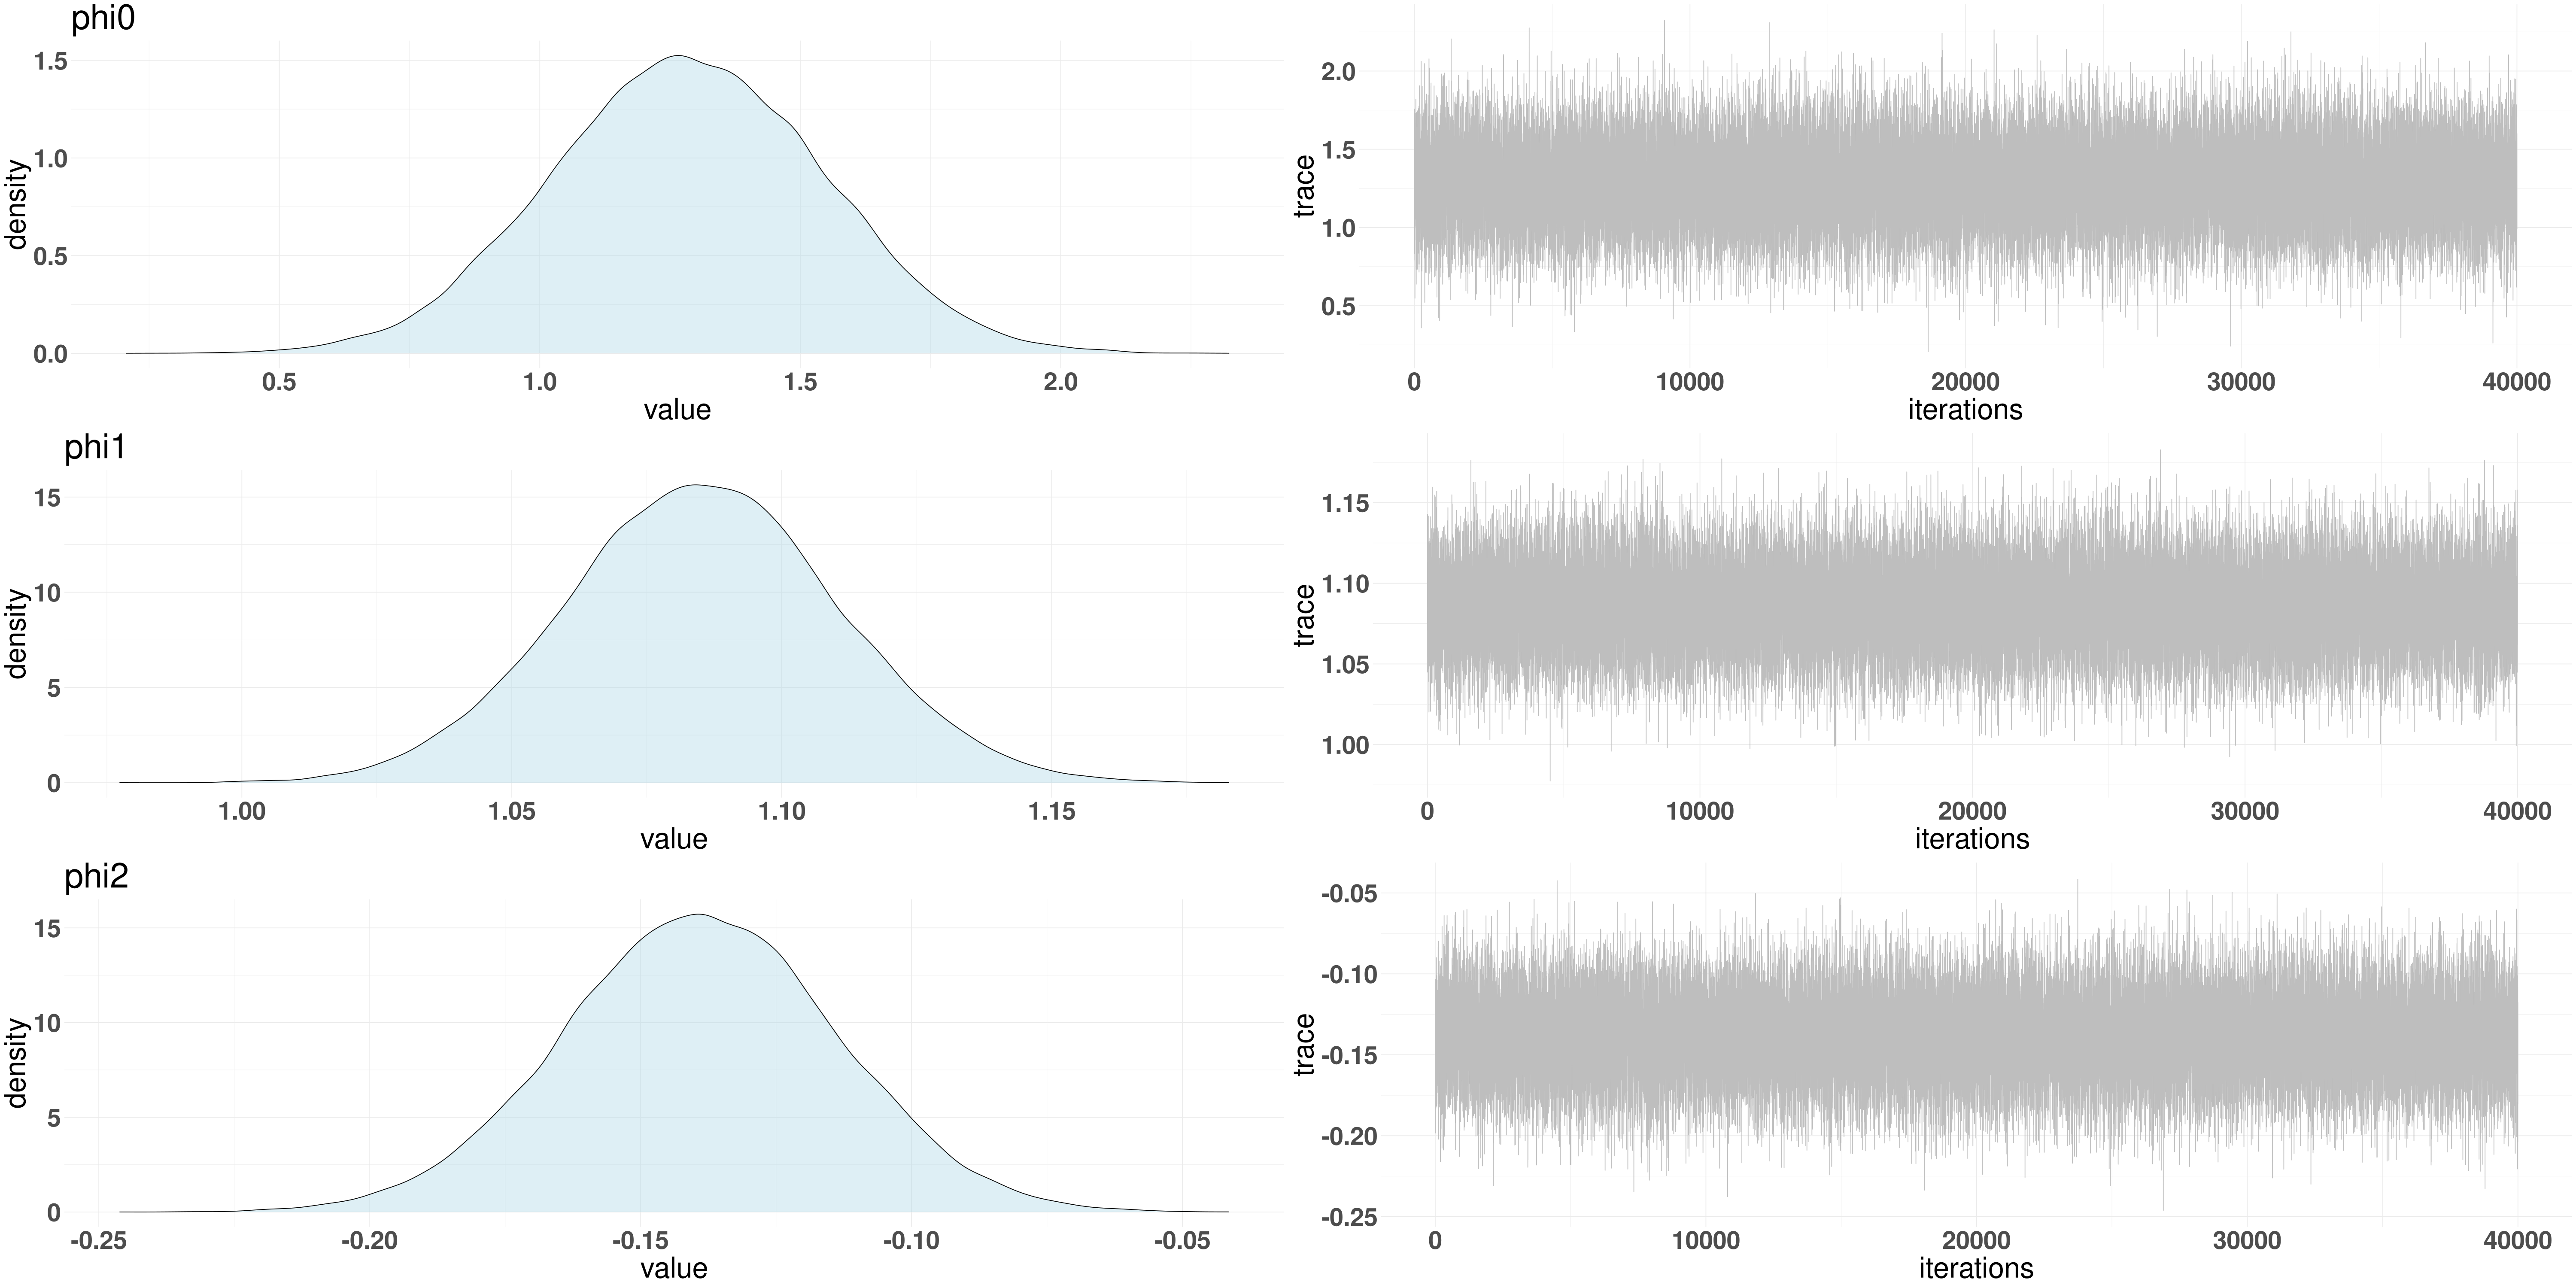

In [209]:
# plot posterior density of parameters togheter with 95% credible intervals
plotPost = function(sample, vars, cI = FALSE){
    # extract samples to plot
    plotData = rstan::extract(sample, vars) %>% 
               as_tibble() %>% 
               map_df(as_data_frame, .id = 'param')
    
    plots = list()
    for(var in vars){
        data = plotData[plotData$param == var,]
        # plot density
        p = ggplot(data, aes(value)) + 
                    geom_density(fill = "lightblue", alpha = 0.4) + 
                    labs(title = var)
        if(cI){
            qu = quantile(data$value, prob = c(0.05, 0.95))
            p = p + geom_vline(xintercept = qu, lty = 2, color = "blue", size = 2)
        }
        plots <- c(plots, list(p))
        # plot traceplot
        p = ggplot(data, aes(x = 1:length(data$value), y = value)) + 
                    geom_line(color = "grey") + 
                    labs(x = "iterations", y = "trace")
        plots <- c(plots, list(p))
    }
    grid.arrange(grobs = plots, nrow = length(vars), ncol = 2)
}

plotPost(AR2sample, c("phi0", "phi1", "phi2"))

Because no of the posterior densities put mass on zero, we are confident that all the parameters are significant to explain the data, meaning that coefficients $\phi_0, \phi_1, \phi_2$ are different from zero. We can be more confident about this assertion by computing the 95% credible intervals and inspect if 0 falls inside or not.

In [9]:
# given an MCMC sample returned by STAN, it computes the credible interval for the requested parameters
# if sig is 1, zero falls outside the credible interval, hence the regressor can be considered significant
credibleParInterval = function(sample, level, vars){
    data = rstan::extract(sample, vars) %>% 
           as_tibble() %>% 
           map_df(as_data_frame, .id = 'param')
    
    cI = data.frame(var = character(), 
                    lwr = numeric(), 
                    mid = numeric(), 
                    upr = numeric(),
                    sig = integer())
    
    for(var in vars){
        qu = quantile(data[data$param == var,]$value, prob = c((1-level)/2, 0.5, (1+level)/2))
        sig = if (qu[1] < 0 && 0 < qu[3]) 0 else 1
        cI[nrow(cI)+1,] = list(var, qu[1], qu[2], qu[3], sig)
    }
    invisible(cI)
}

cI = credibleParInterval(AR2sample, 0.95, c("phi0", "phi1", "phi2"))
cI

,var,lwr,mid,upr,sig
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,phi0,0.7744103,1.2827274,1.78916579,1
2,phi1,1.0354479,1.0851758,1.13531121,1
3,phi2,-0.1890249,-0.1389787,-0.08962124,1


## Forecast

To forecast the time series we need to simulate our model given the estimated parameters and given that

$$
y_t|y_{t-1}, y_{t-2}, \ldots, y_{t-p},{\Phi}, \sigma^{2} \sim \mathcal{N}({f_t}^{T}{\Phi}, \sigma^2)
$$

hence what we do is to take the last p values $y_{t-p}, \ldots, y_{t-1}$ available in the train set, compute the forecast $y_t$ for the next hour, thus compute $y_{t+1}$ using $y_{t-p+1}, \ldots y_{t-1}$ and the forecast $y_t$ obtained at the previous iteration. We proceed in this way until the computation of $y_{t+h}$, where h is the prediction horizon we are interested in.

To obtain the posterior predictive distribution, we compute one value of the forecast $y_t$ for each value of $\Phi$ and $\sigma^2$ in the MCMC sample (which is already a sample from the posterior of the parameters)

In [177]:
ARforecast = function(data, ARpart, intercept = 0, sigma2, horizon){
    order = dim(ARpart)[2]
    params = data.frame(ARpart)
    
    # add as many lags as the order of the AR
    for(i in 1:order){
        colName = sprintf("t-%s", i)
        params[colName] = data[length(data)-(i-1)]
    }
    
    params['intercept'] = intercept
    params['sigma2']    = sigma2   
    # params is a temporary dataframe organized as: AR coefficients | lags | intercept | sigma2
    
    forecast = matrix(NA, nrow = nrow(params), ncol = horizon)
    
    for(i in 1:horizon){
        forecast[, i] = apply(params, 1,
                                 function(x){
                                     # simulate the AR process
                                     mean = x[2*order+1]
                                     for(i in 1:order)
                                         mean = mean + x[i]*x[order+i]
                                     return(rnorm(1, mean, sqrt(x[2*order+2])))
                                 }
                             )
        # shift columns
        for(j in order:2){
            col1 = sprintf("t-%s", j)
            col2 = sprintf("t-%s", j-1)
            params[col1] = params[col2]
        }
        params["t-1"] = forecast[, i]
    }
    
    # return the forecast
    invisible(forecast)
}

# extract parameters from MCMC sample 
params = data.frame(rstan::extract(AR2sample, perm = T))
params['lp__'] = NULL

intercept = params['phi0']
sigma2    = params['sigma2']
ARpart    = params[!names(params) %in% c('phi0', 'sigma2')]

forecast = ARforecast(data      = Ytrain, 
                      ARpart    = ARpart, 
                      sigma2    = sigma2,
                      intercept = intercept,
                      horizon   = 24)

# save the results
save(forecast, file="modelFiles/AR2forecast.dat")

We can now inspect the daily forecast performance of this model, plotting the average hourly forecasted pm2p5 levels togheter with the 95% probability interval

In [110]:
# load the precomputed predictive distribution
load("modelFiles/AR2forecast.dat")

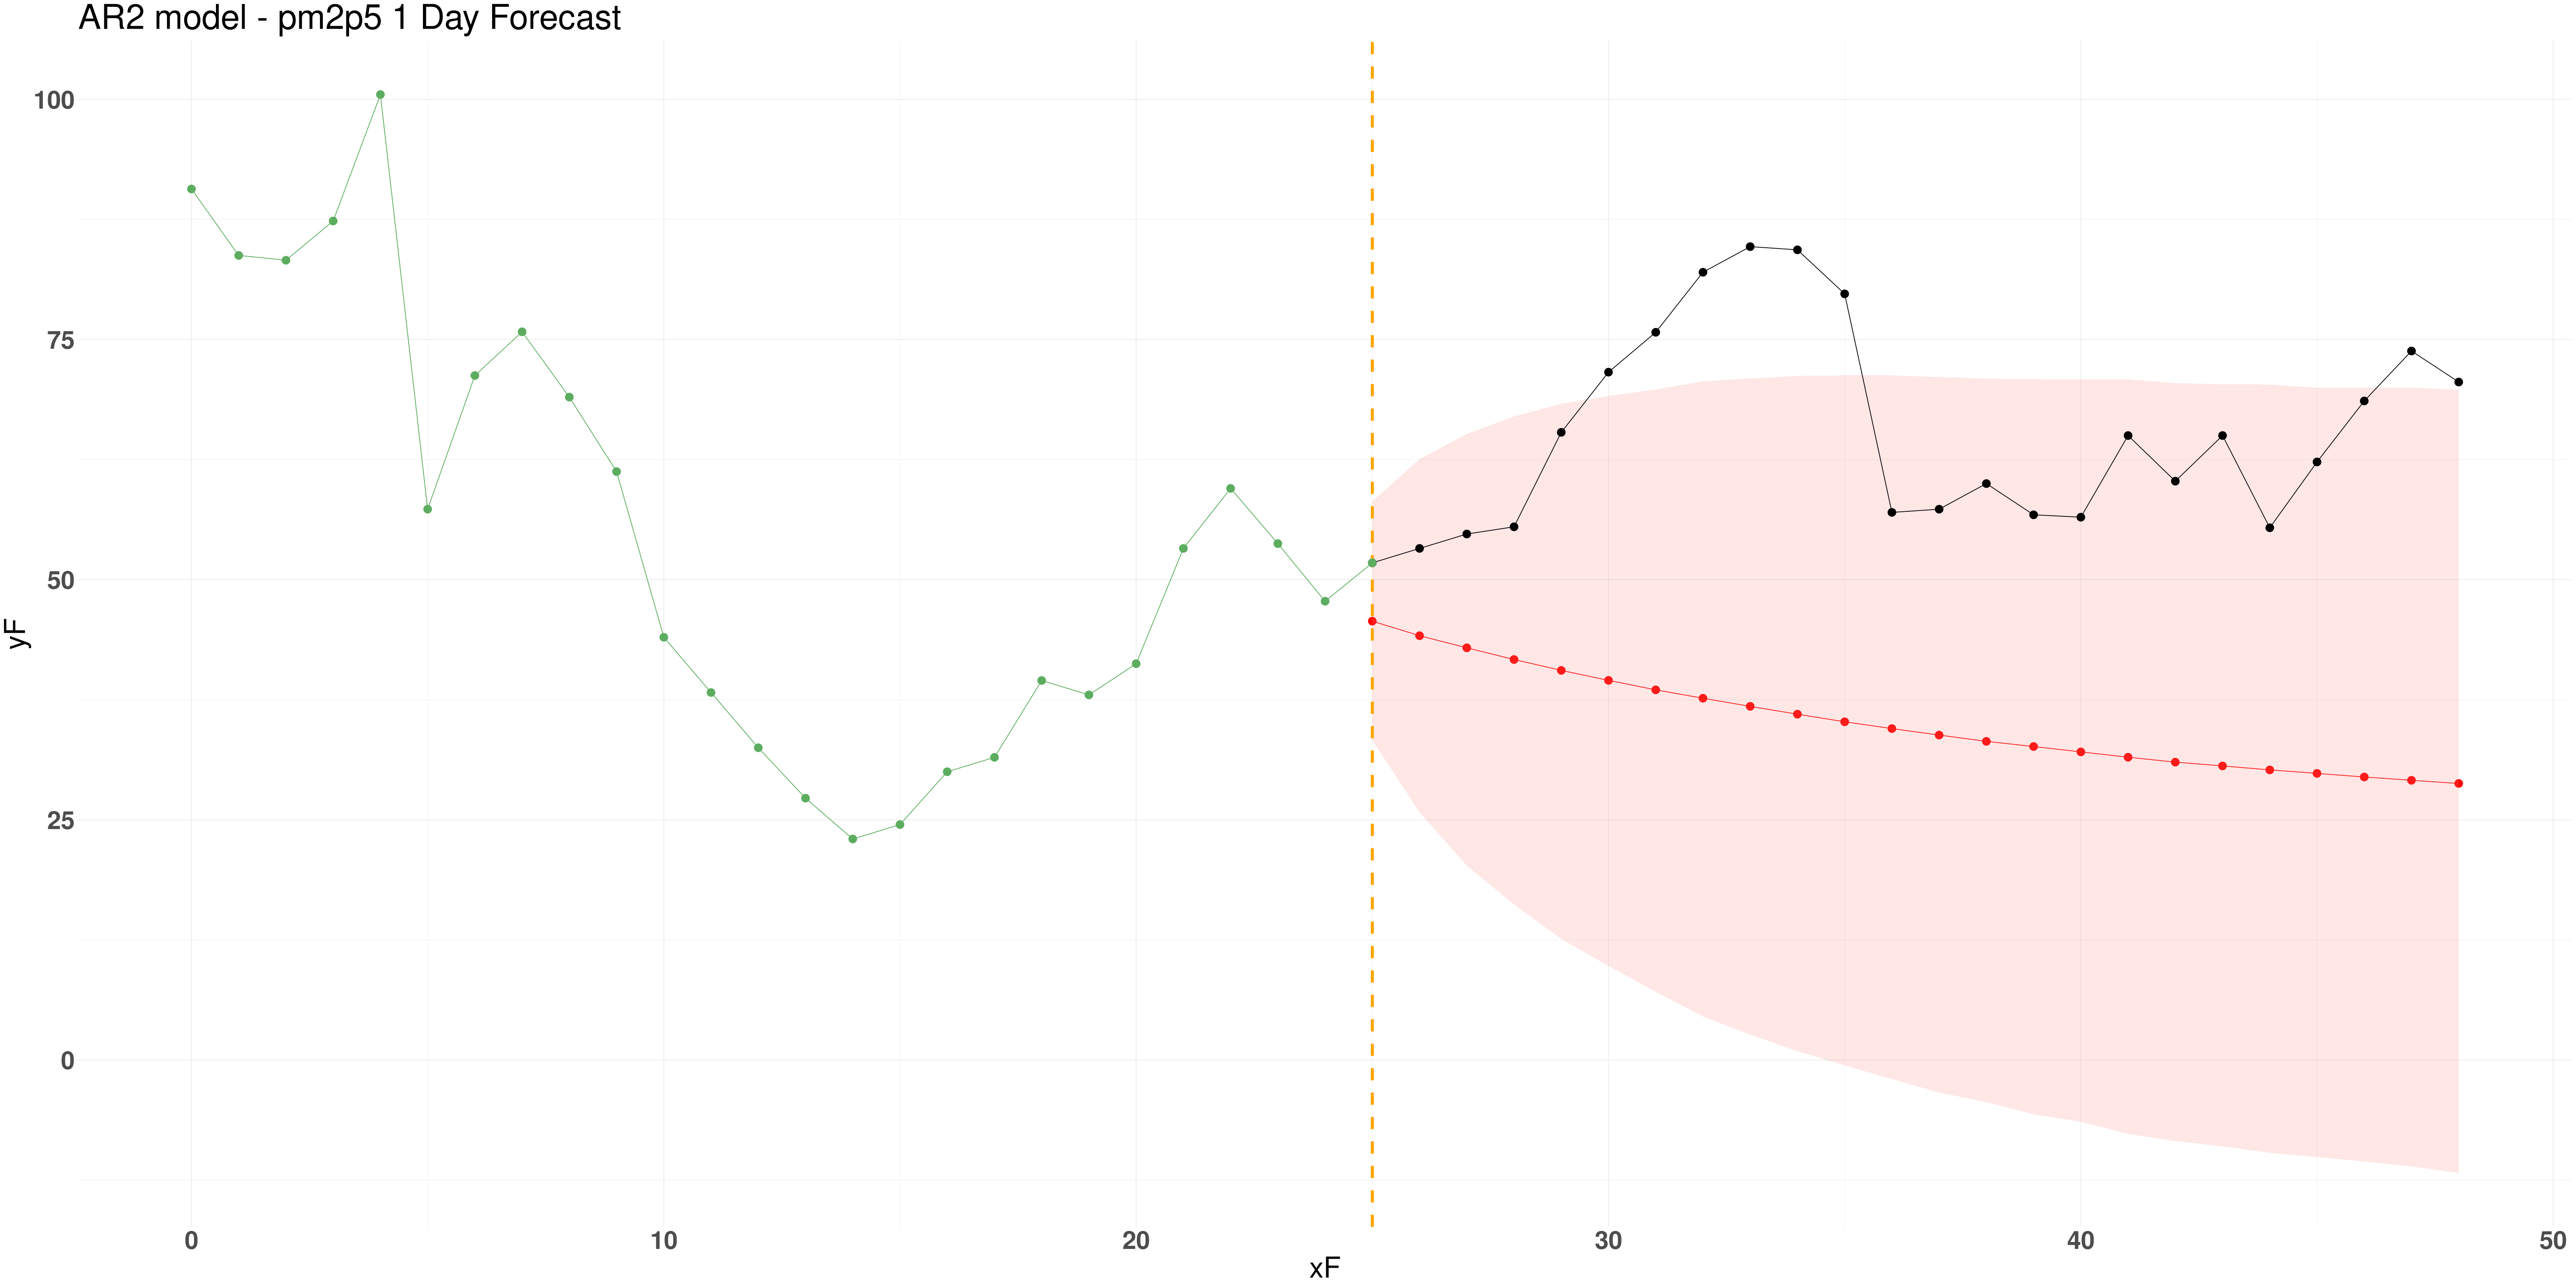

In [225]:
plotForecast  = function(testData, trainData, forecast, title){
    forecastDF = data.frame(yF   = colMeans(forecast),
                            xF   = (1:(length(testData)))+24,
                            ylow = apply(forecast, 2, quantile, p = 0.05),
                            yup  = apply(forecast, 2, quantile, p = 0.95))
    
    trueDF = data.frame(yT = testData,
                        xT = (1:(length(testData)))+24)
    
    # just to plot the last day in train set
    trainDF = data.frame(yTr = c(trainData[(length(trainData)-24):length(trainData)], testData[1]),
                         xTr = 0:25)
    
    # plot forecast
    ggplot(forecastDF) + geom_point(aes(x = xF, y = yF), color = "red", size = 5) +
    geom_line(aes(x = xF, y = yF), color = "red") + 
    geom_ribbon(aes(ymin = ylow, ymax = yup, x = xF), alpha = 0.2, fill = "#ff8a82") + 
    geom_vline(xintercept = 25, lty = 2, color = "orange", size = 2) +
    
    # plot true data
    geom_line(data = trueDF, aes(x = xT, y = yT)) + 
    geom_point(data = trueDF, aes(x = xT, y = yT), color = "black", size = 5) +
    
    # plot the day before
    geom_line(data = trainDF, aes(x = xTr, y = yTr), color = "#5cad5f") +
    geom_point(data = trainDF, aes(x = xTr, y = yTr), color = "#5cad5f", size = 5) +
    ggtitle(title)   
}

plotForecast(Ytest,
             Ytrain, 
             forecast, 
             "AR2 model - pm2p5 1 Day Forecast")

The forecast quality is really bad, not surprising with a so simple model. Morover the prediction variance increases as we go on in the prediction.

## State space representation of AR(p)

Assume that $y_t$ is modeled over time by equations

$$
\begin{align*}
y_t &= F^T \underline x_t + \epsilon_t \\
\underline x_t &= G \underline x_{t-1} + \underline w_t
\end{align*}
$$

An autoregressive model is described in DLM form by the following:

$$
F = [1,0, \ldots, 0]^T \qquad
w_t = [\epsilon_t, 0, \ldots, 0]^T \qquad
G = \begin{bmatrix} 
\phi_1 & 1 & 0 & \ldots & 0 \\
\phi_2 & 0 & 1 & \ldots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
\phi_{p-1} & 0 & 0 & \ldots & 1 \\
\phi_p & 0 & 0 & \ldots & 0 \\
\end{bmatrix}
$$

* possiamo provare a selezionare l'ordine p del modello in modo bayesiano, quindi dobbiamo riuscire a calocare i vari indici tipo WAIC,... e poi lavorare con una griglia di valori per p


* prova a vedere se si può parametrizzare un modello da stan, cioè se voglio fittare un AR(p) con p che va da 1 a 20, non devo stare a scrivere 20 .stan diversi... forse se passiamo p come dato a stan è possibile scrivere la likelihood di conseguenza... idea:

```
media = beta[0] // intercetta
for(i in 1:p){
    media = media + beta[p]*y[t-p] // buh non so se si può fare
}
...
for(t in 3:N){
    Y[t] ~ normal(media, pow(sigma2, 0.5));
}

```
    e poi dobbiamo definire un vettore delle beta di p+1 elementi e le prior. Se si può fare stiamo apposto anche per ARMA... mmhh c'è quel blocco "transformed parameters" nel regression2.stan in TA11, potrebbe essere un idea. Idea finale: Possiamo fare come nel regression2.stan (sempre TA11) e passare noi una design matrix ad hoc per un AR(p) di qualunque ordine da R. quindi wrappiamo stan in una funzione R che preso l'ordine p prepara la design matrix e la passa come input in stan.

* inventarci dei plot di diagnostica da usare in tutti i modelli futuri.come valutiamo la goodness of fit del modello?? ci serve un indice per dire quanto la predizione si scosta dal valore reale, robe tipo datamining (RMSE?? sempre meglio ragionare in termini bayesiani predittivi)

cose da implementare
* log pseudo marginal likelihood LPML (che richiede il calcolo del CPO_i), comunque parliamo di predictive goodness of fit

* posterior preedictive check (calcola per ogni punto un 95% credible interval e controlla se il vero valore è contenuto o meno in questo intervallo)

* posterior predictive p-values, che è il modo formale per fare quello del punto prima (che invece è un po una cosa grafica a caso) https://stats.stackexchange.com/questions/69633/whats-the-bayesian-equivalent-of-a-general-goodness-of-fit-test bayesian p-value: se {y1,...yn} è un MCMC sample dalla distributione predittiva di Y_{t+1}, che è una normale una volta condizionata, il p-value bayesiano è calcolato come
$$
\frac{1}{n} \sum_{i=1}^n \mathbb{1}_{y_i > y^*}
$$
dove $y^*$ è il vero valore di Y_{t+1}. Vogliamo che questo p-value sia circa 0.5, o comunque lontano dallo 0. controllare se c'è già una funzione di R che lo calcola in automatico (Gugli lo calcola a mano)

* WAIC (funzione rigo 469 in TA11.r, in più bisogna dire a stan di farci ritornare la log density come generated quantities con normal_lpdf)

* LOO-CV (dovrebbe già esserci la funzione loo() di R che lo fa in automatico). https://mc-stan.org/loo/articles/loo2-example.html, (anche ma non troppo: pagina 26 di "Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC" (file loo_stan.pdf in cartella bayesian))
nell'ouput di loo(), il leave one out information criterion (looic) è definito come (preso dall'articolo)
$$
\text{LOOIC} = -2\text{LPML}
$$


* vedi sezione 6 del bayesian workflow di Gugli

* idee per il monitoring, cioè qualche indice e qualche idea per diagnostica: pag 135 libro beraha (anche se li siamo già nei DLM... però fa lo stesso)

* calcolo della gelman-rubin diagnostic per vedere se il sampling è buono, più un summary del sampling per ogni parametro (tipo rigo 88 del TA11.r di corradin, anche se c'è già qualcosa nella cella 8...)

* per ARMA (che alla fine è un modello di regressione identico ad AR ma con in più i valori dell'errore ai tempi precedenti), sul sito di stan c'è questo: https://mc-stan.org/docs/2_25/stan-users-guide/autoregressive-moving-average-models.html, che dà un idea di come scrivere un ARMA in stan

* dopo AR e ARMA passerei direttamente ai DLM, decisamente più facile gestire la parte seasonal! Possiamo definire un DLM con la sola parte autoregressiva + seasonal (senza introdurre la parte regressiva, se vogliamo procedere a step graduali di complessità del modello...)